## 0. Prepare Environment
### Import relevant packages

In [3]:
from GPR import GPR
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy import linalg
import matplotlib as pl
# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 

## 1. Gaussian Process Regression

###  Load Data

Data obtained from NOAA ESRL: "NOAA Earth System Research Laboratories (ESRL) pursue a broad and comprehensive understanding of the many physical, chemical and biological processes that comprise the Earth..."

https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_gl.csv

     year  month   decimal  average  average_unc   trend  trend_unc
0    1979      1  1979.042   336.56         0.10  335.92       0.09
1    1979      2  1979.125   337.29         0.09  336.25       0.09
2    1979      3  1979.208   337.88         0.10  336.51       0.09
3    1979      4  1979.292   338.32         0.11  336.72       0.09
4    1979      5  1979.375   338.26         0.04  336.71       0.10
..    ...    ...       ...      ...          ...     ...        ...
524  2022      9  2022.708   414.60         0.10  417.45       0.06
525  2022     10  2022.792   416.12         0.10  417.68       0.06
526  2022     11  2022.875   417.73         0.10  417.94       0.06
527  2022     12  2022.958   418.77         0.10  418.16       0.06
528  2023      1  2023.042   419.31         0.10  418.24       0.06

[529 rows x 7 columns]


<AxesSubplot:xlabel='decimal'>

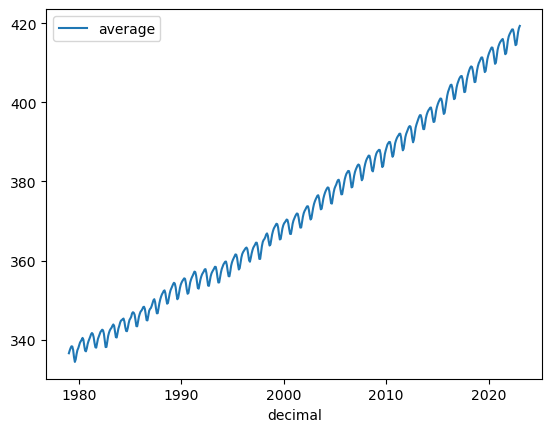

In [4]:
# Actual line to load dataset
# Very important to use comment='#', since the csv file contains introductory comments that need to be ignored
df_co2 = pd.read_csv('https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_gl.csv', comment='#')

print(df_co2)

#Plot the data
df_co2.plot('decimal','average')

The column *decimal* was calculated by NOAA in order to match date as a decimal number corresponding to the day at the middle of each month:

\begin{equation}
\text{decimal} = \text{year}+\frac{\text{month}-0.5}{12}
\end{equation}

### Preprocess Data

#### Filter Data

The following block of code filters the useful columns (*decimal, average*) and keeps only the observations with dates we are interested in.

In [5]:
df_co2 = df_co2[['decimal','average']] # Keep only the columns decimal and average

df_co2_filtered = df_co2[(df_co2['decimal'] >= 2016) & (df_co2['decimal'] < 2019)]

print(df_co2_filtered)

      decimal  average
444  2016.042   402.64
445  2016.125   403.27
446  2016.208   403.86
447  2016.292   404.39
448  2016.375   404.45
449  2016.458   403.66
450  2016.542   402.11
451  2016.625   400.80
452  2016.708   400.99
453  2016.792   402.42
454  2016.875   403.78
455  2016.958   404.69
456  2017.042   405.32
457  2017.125   405.91
458  2017.208   406.32
459  2017.292   406.61
460  2017.375   406.65
461  2017.458   405.86
462  2017.542   404.11
463  2017.625   402.57
464  2017.708   402.66
465  2017.792   404.16
466  2017.875   405.70
467  2017.958   406.75
468  2018.042   407.56
469  2018.125   408.24
470  2018.208   408.77
471  2018.292   409.08
472  2018.375   408.94
473  2018.458   408.06
474  2018.542   406.47
475  2018.625   405.10
476  2018.708   405.17
477  2018.792   406.65
478  2018.875   408.13
479  2018.958   409.18


#### Transform (extract) data from Pandas dataframe to Numpy array

In [6]:
x = df_co2_filtered['decimal'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = df_co2_filtered['average'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

x has shape (36,1) and has range [2016.042,2018.958]
y has shape (36,1) and has range [400.800,409.180]


#### Plot data

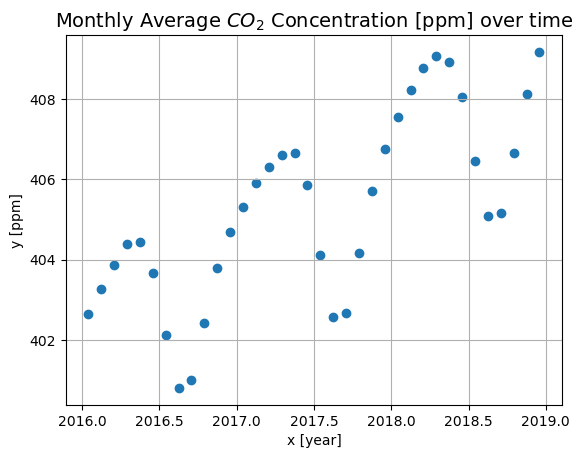

In [7]:
import matplotlib.pylab as pl
%matplotlib inline

#scatter plot of y vs. x
pl.scatter(x, y) # Interpolation data
pl.title('Monthly Average $CO_2$ Concentration [ppm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [ppm]')
pl.grid()

#### Normalisation

Let us normalise the training data between 0,1.

In [8]:
def normalise1D(z, new_min=0, new_max=1): 
    z_min = np.min(z)
    z_max = np.max(z)
    z_normalised = new_min + (z - z_min)*(new_max - new_min)/(z_max - z_min) 
    return z_normalised

x_norm = normalise1D(x) # You could overwrite x, however I recommend to create a new variable to avoid loosing track of variables
y_norm = normalise1D(y)

y_norm = y_norm - np.mean(y_norm)

#### Split training (70%) and for interpolation test (30%) set 

Training set contains 25 observations.
Training set contains 11 observations.


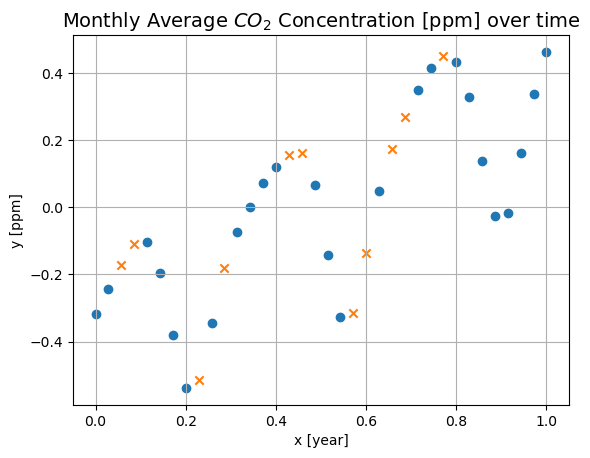

In [9]:
random_indices = np.random.permutation(x.shape[0])
train_ratio = .7
n_train = int(np.floor(x_norm.shape[0]*train_ratio))
n_test = x_norm.shape[0]-n_train
train_idx, test_idx = random_indices[:n_train], random_indices[n_train:]
x_norm_train, x_norm_test = x_norm[train_idx,:], x_norm[test_idx,:]
y_norm_train, y_norm_test = y_norm[train_idx,:], y_norm[test_idx,:]

print(f"Training set contains {y_norm_train.shape[0]} observations.")
print(f"Training set contains {y_norm_test.shape[0]} observations.")

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.title('Monthly Average $CO_2$ Concentration [ppm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [ppm]')
pl.grid()

#### GP Regression Implementation



We need to calculate the posterior predictive distribution:

\begin{equation}
p(\mathbf{f}_* | \mathbf{X},\mathbf{y}, \mathbf{x}_*) = \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*))
\end{equation}

\begin{equation}
\bar{\mathbf{f}}_* = K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}\mathbf{y}
\end{equation}

\begin{equation}
\text{cov}(\mathbf{f}_*) = K(\mathbf{x}_*,\mathbf{x}_*) - K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}K(\mathbf{X},\mathbf{x}_*)
\end{equation}


This class incorporates the caluclation of the log marginal likelihood – so we can find the best hyperparameters to fit the data:

\begin{equation}
p(\mathbf{y}|\mathbf{X}) = \int{p(\mathbf{y}|\mathbf{f},\mathbf{X})p(\mathbf{f}|X)}\text{d}\mathbf{f}
\end{equation}

\begin{equation}
\text{log}p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}\mathbf{y}^T\left(K+\sigma_n^2I\right)\mathbf{y} - \frac{1}{2}\text{log}|K+\sigma_n^2I|-\frac{N}{2}\text{log}2\pi
\end{equation}


Log Marginal Likelihood: [[-109.59865145]]


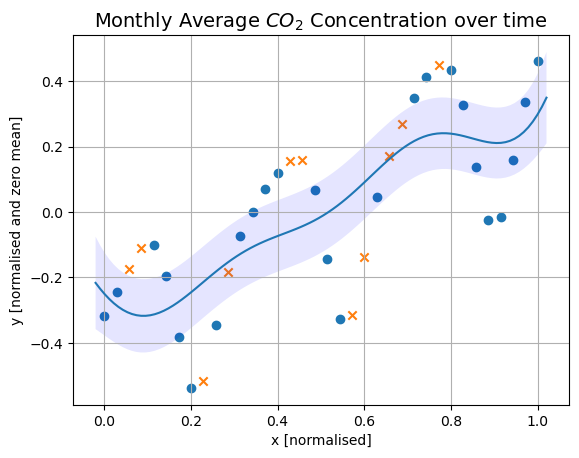

In [10]:
x_star = np.linspace(-0.02,1.02,100)[:,np.newaxis] 
signal_variance = 1 #1
lengthscale = 0.1 #0.3
sigma_n = 0.05#0.1
gp = GPR("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n)
[f_mean_2,f_std_2] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean_2)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()


In [26]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    gp.set_hyper_params(params[:-1],params[len(params)-1])
    nlml = -gp.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(1), np.log(0.04), np.log(0.05)])
res = minimize(eval_params, x0, method='nelder-mead', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

[1.   0.04 0.05][[13.2191557]]
[1.00025003 0.04       0.05      ][[13.215658]]
[1.        0.0340536 0.05     ][[4.13613136]]
[1.         0.04       0.04304458][[18.77934407]]
[1.00016668 0.03593039 0.05807932][[3.31879068]]
[1.00025003 0.0340536  0.06746414][[-0.61409996]]
[1.00033339 0.03227483 0.06105277][[-1.17729942]]
[1.00050013 0.02899119 0.06746414][[-4.245284]]
[1.00025003 0.02604162 0.0745488 ][[-5.79162597]]
[1.00025003 0.02101222 0.09102821][[-6.21571526]]
[1.00066689 0.02217027 0.11115048][[-5.02018591]]
[1.00069469 0.01665366 0.11491249][[-4.37035074]]
[1.00057424 0.01351769 0.16389412][[-0.06165265]]
[1.00051865 0.0239566  0.08422589][[-6.22996955]]
[1.00026238 0.02998719 0.07822065][[-4.27916294]]
[1.00058659 0.01929151 0.10437723][[-5.41620079]]
[1.00023665 0.02053074 0.07754853][[-6.55036113]]
[1.00002161 0.01975701 0.06477459][[-6.04049134]]
[1.00008368 0.02459432 0.06774195][[-5.80462218]]
[1.00020938 0.02314556 0.07547354][[-6.37980952]]
[1.00039308 0.02408387 0.068

Optimal signal variance: 0.08341587591210169
Optimal lengthscale: 0.00374340634287205
Optimal noise std: 0.0018343377828704413


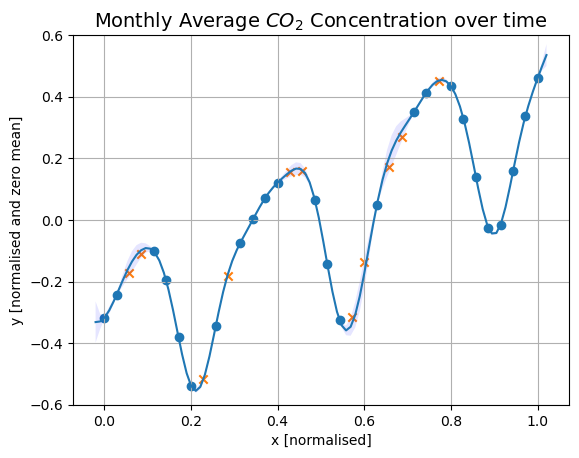

In [27]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[2]))

gp.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])

#Predict for x_star
[f_mean,f_std] = gp.predict(x_star)

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-0.6,0.6])
pl.grid()

#### Warped GP Regression Implementation

The warped GP class is similar to the regular GP class, but it has the following differences:

- The target variable is warped (y_train). In this case, the warping function is a sum of hyperbolic tangents.
- The parameters of the warping functions are incorporated into the `log_marginal_likelihood` and optimized along with the GP's hyperparameters. It would look like this: 

\begin{equation}
\text{log}p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}f(\mathbf{y})^T\left(K+\sigma_n^2I\right)f(\mathbf{y}) - \frac{1}{2}\text{log}|K+\sigma_n^2I|-\frac{N}{2}\text{log}2\pi + \sum_{i=1}^Nlog(\frac{\partial{f(\mathbf{y}_n)}}{\partial{\mathbf{y}_n}})
\end{equation}

with $f$ the warping function and $N$ the number of observations.

In order to implement these two changes however, an extensive number of changes have to be implemented.

Now let us plot a regression with an arbitrary value for the hyperparameters to see that the predict function is warping properly

Log Marginal Likelihood: [[-63.37976752]]


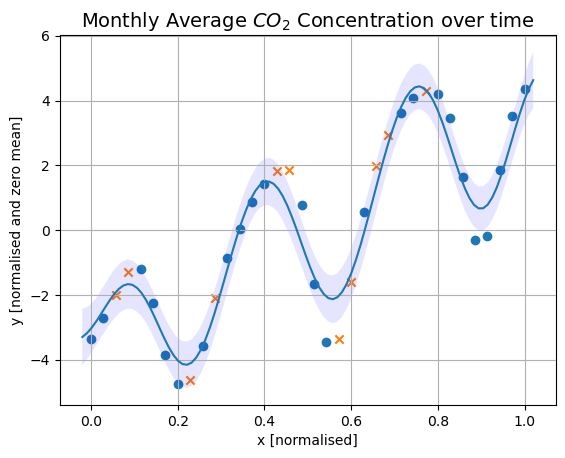

In [47]:
I = 3
val_a = 2 
val_b = 2
val_c = 0
a = np.full(I, val_a)
b = np.full(I, val_b)
c = np.full(I, val_c)

nuv = 1/2
signal_variance = 1
lengthscale = 0.01
sigma_n = 0.3


gpw = GPR("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n,[a,b,c], nuv)
[fw_mean_2,fw_std_2] = gpw.predict(x_star)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
fw_norm_train = 0
fw_norm_test = 0
for i in range(I):
    fw_norm_train += a[i]* np.tanh(b[i] * (y_norm_train + c[i])) 
    fw_norm_test += a[i] * np.tanh(b[i] * (y_norm_test + c[i])) 


pl.scatter(x_norm_train, fw_norm_train)
pl.scatter(x_norm_test, fw_norm_test,marker="x")

pl.fill_between(x_star.ravel(), (fw_mean_2-2*fw_std_2).ravel(), (fw_mean_2+2*fw_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, fw_mean_2)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()


Now optimize the hyerparameters, including the parameters of the warping function, using the `log_marginal_likelihood()` and `set_hyper_params()` functions. 

In [57]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    a = [params[3+3*i] for i in range(I)]
    b = [params[4+3*i] for i in range(I)]
    c = [params[5+3*i] for i in range(I)]
    gpw.set_hyper_params(params[:2], params[2], [a,b,c])
    nlml = -gpw.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(2), np.log(0.003)]  + [np.log(0.015)] + [np.log(2), np.log(2), np.log(0.03)]*I)
res = minimize(eval_params, x0, method='powell', args=(gpw),
               options={'xatol': 1e-10, 'disp': True})
print(res)

C:\Users\23478671\AppData\Local\Temp\ipykernel_4268\632745638.py:14: OptimizeWarning: Unknown solver options: xatol
  res = minimize(eval_params, x0, method='powell', args=(gpw),
c:\Users\23478671\Github\Warped-GPs-\GPR.py:88: RuntimeWarning: divide by zero encountered in log
  lml4 = np.sum(np.log(self.df_dy))


[2.    0.003 0.015 2.    2.    0.03  2.    2.    0.03  2.    2.    0.03 ][[-3.15196749]]
[2.    0.003 0.015 2.    2.    0.03  2.    2.    0.03  2.    2.    0.03 ][[-3.15196749]]
[5.43656366e+00 3.00000000e-03 1.50000000e-02 2.00000000e+00
 2.00000000e+00 3.00000000e-02 2.00000000e+00 2.00000000e+00
 3.00000000e-02 2.00000000e+00 2.00000000e+00 3.00000000e-02][[-18.83542716]]
[2.74174914e+01 3.00000000e-03 1.50000000e-02 2.00000000e+00
 2.00000000e+00 3.00000000e-02 2.00000000e+00 2.00000000e+00
 3.00000000e-02 2.00000000e+00 2.00000000e+00 3.00000000e-02][[-12.37442431]]
[5.43656366e+00 3.00000000e-03 1.50000000e-02 2.00000000e+00
 2.00000000e+00 3.00000000e-02 2.00000000e+00 2.00000000e+00
 3.00000000e-02 2.00000000e+00 2.00000000e+00 3.00000000e-02][[-18.83542716]]
[1.00863311e+01 3.00000000e-03 1.50000000e-02 2.00000000e+00
 2.00000000e+00 3.00000000e-02 2.00000000e+00 2.00000000e+00
 3.00000000e-02 2.00000000e+00 2.00000000e+00 3.00000000e-02][[-18.96246275]]
[1.4778112e+01 3.00000

These are the optimal hyperparameters to fit this data with a GP. Visualize the predictions now with the optimised hyperparameters

Optimal signal variance: 3.8598061845460383
Optimal lengthscale: 0.003976299554017882
Optimal noise std: 0.01751827293295425
Optimal a1:10.213922025398034
Optimal b1:0.19982419772482107
Optimal c1:1.7430824426675944e-13
Optimal a2:3.946711193194141
Optimal b2:0.424718847454569
Optimal c2:8.228183795027171e-14
Optimal a3:5.860982916051615
Optimal b3:0.49027646648990175
Optimal c3:3.014937963854266e-14
Log Marginal Likelihood: [[25.97206757]]


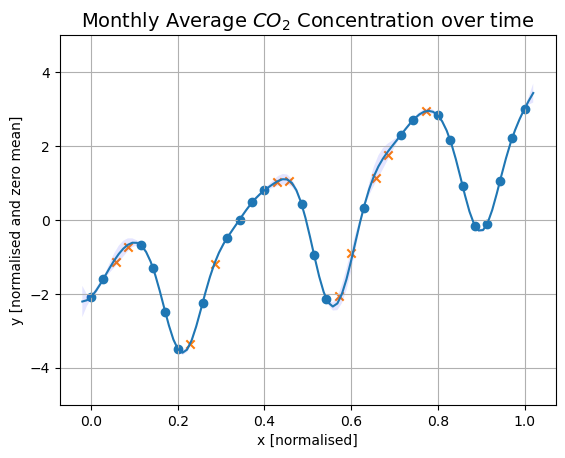

In [62]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[2]))
for i in range(I):
    print(f'Optimal a{i+1}:' +str(optimal_params[3+3*i]))
    print(f'Optimal b{i+1}:' +str(optimal_params[4+3*i]))
    print(f'Optimal c{i+1}:' +str(optimal_params[5+3*i]))  

a = [optimal_params[3+3*i] for i in range(I)]
b = [optimal_params[4+3*i] for i in range(I)]
c = [optimal_params[5+3*i] for i in range(I)]

gpw.set_hyper_params(optimal_params[:2], optimal_params[2], [a,b,c])

#Predict for x_star
[fw_mean,fw_std] = gpw.predict(x_star)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))


fw_norm_train = 0
fw_norm_test = 0

for i in range(I):
    fw_norm_train += optimal_params[3*i+3] * np.tanh(optimal_params[3*i+4] * (y_norm_train + optimal_params[3*i+5])) 
    fw_norm_test += optimal_params[3*i+3] * np.tanh(optimal_params[3*i+4] * (y_norm_test + optimal_params[3*i+5])) 

pl.scatter(x_norm_train, fw_norm_train)
pl.scatter(x_norm_test, fw_norm_test,marker="x")

pl.fill_between(x_star.ravel(), (fw_mean-2*fw_std).ravel(), (fw_mean+2*fw_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, fw_mean)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-5,5])
pl.grid()

### Compare the GP and WGP regressions

Get the predictions with the optimised hyperparameters for the GP and the WGP. In the WGP's case, we're predicting the unwarped y's with the `predict_original` function (but with the WGP-optimised hyper parameters).

In [93]:
[f_mean,f_std] = gp.predict(x_norm_test)
[fw_mean,fw_std] = gpw.predict_original(x_norm_test)

In [60]:
maewarp = np.mean(np.abs(fw_mean - y_norm_test))
mae = np.mean(np.abs(f_mean - y_norm_test))
print("GP MAE:",mae )
print("Warped GP MAE:",maewarp)

GP MAE: 0.014158825019373118
Warped GP MAE: 0.012691464416259846


(array([[0., 0., 1., 1., 4., 2., 2., 1., 0., 0.],
        [0., 0., 1., 1., 4., 2., 2., 1., 0., 0.],
        [0., 0., 1., 1., 4., 3., 1., 1., 0., 0.]]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 3 BarContainer objects>)

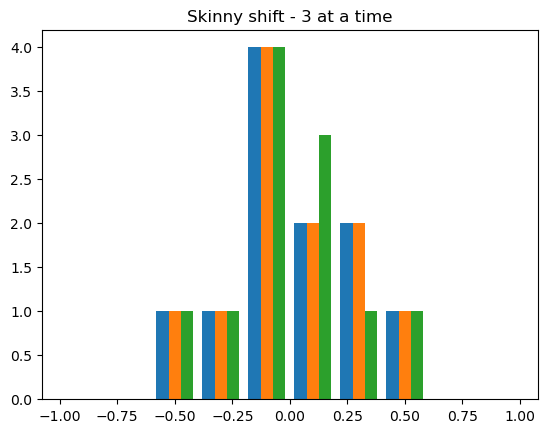

In [97]:
import matplotlib.pyplot as plt
a = np.array(f_mean).reshape(-1)
b = np.array(fw_mean).reshape(-1)
c = np.array(y_norm_test).reshape(-1)
common_params = dict(bins=10, range=[-1, 1])
plt.title('Skinny shift - 3 at a time')
plt.hist((a, b, c), **common_params)

As expected, for regular data of this kind the different shouldn't be big. 